<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Generating-Data-for-Motorway-Speed" data-toc-modified-id="Generating-Data-for-Motorway-Speed-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Generating Data for Motorway Speed</a></span></li></ul></div>

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
import numpy as np
import random

import simpy
import simpy.events as evt

# Generating Data for Motorway Speed

Sources: [RSA Free Speed Survey 2011](https://www.rsa.ie/Documents/Road%20Safety/Speed/Speed_survey_2011.pdf)
and 
[RSA Free Speed Survey 2018](https://www.rsa.ie/Documents/Road%20Safety/Speed/RRD_Res_20190204_FreeSpeedSurvey2018FINAL.pdf)

A survey of 1200 Irish drivers gives the following distribution of free speed on a motorway:

<img src='FreeSpeed.png' width=600/>

As the Survey Data are not actually available, we generate a sample matching this histogram:

In [3]:
free_speed = [ 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170 ]
quantiles = np.cumsum([0, 0.003, 0.014, 0.052, 0.148, 0.27, 0.309, 0.143, 0.048, 0.01, 0.003])

def random_speed():
    u = random.random() # generates uniformly distributed random number between 0 and 1
    for i in range(len(quantiles)):
        if u<quantiles[i+1]:
            p = (u-quantiles[i])/(quantiles[i+1]-quantiles[i])
            return free_speed[i]*p+free_speed[i+1]*(1-p)

In [4]:
quantiles

array([0.   , 0.003, 0.017, 0.069, 0.217, 0.487, 0.796, 0.939, 0.987,
       0.997, 1.   ])

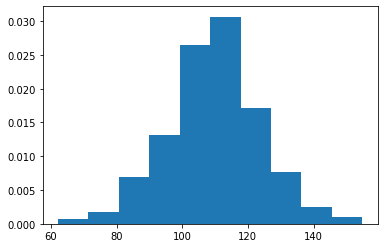

In [5]:
random.seed(0)
speeds = [ random_speed() for i in range(1200)]
hist = plt.hist(speeds, bins=10, density=True)

This simple approach generates however a stepwise distribution function, which may have undesired side effects for large sample sets, as we can see in this example:

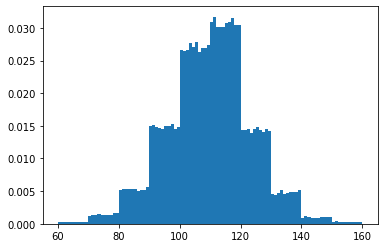

In [6]:
random.seed(0)
speeds = [ random_speed() for i in range(100000)]
hist = plt.hist(speeds, bins=100, density=True)

Based on the reconstructed survey data we generate a gaussian kernel that matches the histogram;

In [7]:
random.seed(0)
speeds = [ random_speed() for i in range(1200)]
kernel = stats.gaussian_kde(speeds)

The plot below shows an overlay of the kernel distribution function with the original histogram:

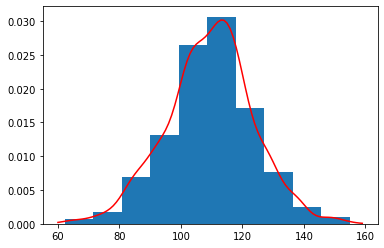

In [8]:
plt.hist(speeds, bins=10, density=True)
x = np.arange(60, 160, 1)
y = kernel(x)
plot = plt.plot(x, y, color='red')

We integrate the kernel and define a new generator for random speed data that follows the kernel distribution function:

In [9]:
v = np.arange(30, 191)
q = [ kernel.integrate_box_1d(30, i) for i in v ]

def freeMotorwaySpeed():
    u = random.random() # generates uniformly distributed random number between 0 and 1
    for i in range(len(q)):
        if u<q[i+1]:
            p = (u-q[i])/(q[i+1]-q[i])
            # return (free_speed[i+1]+free_speed[i])/2*p+(1-p)*(free_speed[i+1]+free_speed[i+2])/2
            return v[i]*p+v[i+1]*(1-p)

To test the new rspeed generator for speed data we generate a large number of test data and check the distribution:

In [12]:
random.seed(0)
rspeeds = [ freeMotorwaySpeed()/3.6 for i in range(100000) ]

In [13]:
rspeeds

[34.37789385828867,
 32.80127611448126,
 29.970375738959977,
 27.838733516836296,
 30.740261665353803,
 29.574560878492196,
 33.60420051998618,
 28.428176005602673,
 30.52099808181858,
 31.174890896426934,
 35.8066471623611,
 30.80319486315024,
 28.1176596070567,
 32.82501999225988,
 31.407998490444985,
 27.94597429844931,
 35.76350158399267,
 39.12826447083999,
 33.80418846116246,
 35.398594083706634,
 28.35123825115963,
 32.55263291100776,
 35.48003274607223,
 32.458234700524386,
 30.00906435019624,
 25.176885455696805,
 29.832917929985893,
 31.476894510109133,
 35.677261785416775,
 37.52381364388451,
 30.51697134034584,
 34.5452781936669,
 27.81864361420607,
 33.87970611478542,
 30.941550735397083,
 21.360408228651735,
 32.657236047961746,
 29.637134863746237,
 34.144713585042524,
 32.054050829521316,
 17.39821272458066,
 30.355363310556815,
 34.50044862466674,
 28.030072797259038,
 28.743116927973347,
 34.99991363924079,
 27.15016989501961,
 31.32168340844161,
 27.545639548642242,


With a small number of bins we demonstrate that it matches the original survey data:

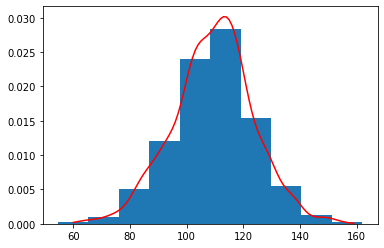

In [16]:
h = plt.hist(rspeeds, bins=10, density=True)
x = np.arange(60, 160, 1)
y = kernel(x)
plot = plt.plot(x, y, color='red')

And a *high-resolution* histogram demonstrates that the random variables are smoothly distributed:

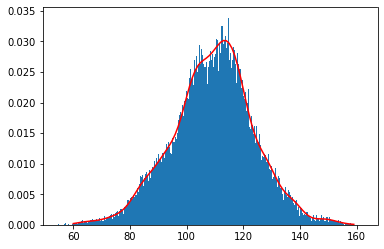

In [17]:
h = plt.hist(rspeeds, bins=1000, density=True)
x = np.arange(60, 160, 1)
y = kernel(x)
plot = plt.plot(x, y, color='red')